 # Create Service Use Timelines from client data stored in Carenotes

 This code will create a Service Use Timeline for each individual client based on their service use as recorded in Carenotes.

 For each Service Use Timelime, the x axis is the full 3 year timeline & the y axis is the individual services accessed, with the option to rank the services chronologically or by cost. The duration of the service use is represented by a horizontal bar. The setting and locality of each service is shown by a colour code, and the individual contacts the client had with the service are represented by dots within the service use bar.
 
 This example uses anonymised client data.

 This Jupyter Notebook extends the code provided here: https://sukhbinder.wordpress.com/2016/05/10/quick-gantt-chart-with-matplotlib/

 ### Using this Jupyter Notebook
 Jupyter Notebooks are an efficient way to embed lots of text (to provide extensive descriptions) with live code.  Each cell is defined as either Code (depicted by a grey box) or Markdown (the comments which have no visual box, like this part). Both parts can be edited by the user.

 For an introduction to Jupyter Notebooks please see https://www.datacamp.com/community/tutorials/tutorial-jupyter-notebook##UseJupyter.

 - This is your own copy of this Notebook - feel free to edit it as you like (or save another copy to edit instead).
 - Double-click on cells to edit them.
 - To execute a single cell, click the "Run" button on a selected cell, or press Shift+Enter, or in the menu select "Cell" & "Run cells"
 - Every time you make a change to a cell, you will need to execute all the cells that need updating.  There are options to run all cells and to run all cells above a selected cell (under the menu "Cell")

 ### Python

 Python is a very flexible programming language that is designed to be powerful and intuitive. The best way to learn a programming language like python is to experiment with working code: breaking it, fixing it and learning a bit of whatever you need when you need it. An excellent introduction to python, specifically applied to healthcare is https://pythonhealthcare.org/.

 ## Import libraries

 The Service Use Timelines are created using the matplotlib library.

 We will also use the libraries: numpy, pandas and datetime to manipulate our data to be in the right format for matplotlib.

 Let's import our libraries

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates
from matplotlib.dates import MONTHLY, DateFormatter, rrulewrapper, RRuleLocator
import sys


# Definitions of terms

*Episode*: a single record in the dataset that represents a single use of service (a service use episode).<br>
*Client*: a unique patient in the dataset. A client will have one or more episodes.<br>

#### The variables in the mock Carenotes dataset
For this code, a mock Carenotes dataset is provided. It contains anonymised client data. The variables include both those that are currently held in Carenotes, and mockup versions of additional variables as requested by the user.

*ClientID*: Unique code for each individual client<br>
*ICD10*: ICD10 code<br>
*Desc*: ICD10 code description<br>
*Cluster*: Mental health cluster code<br>
*ReferralDate*: Service use start date<br>
*ReferralDischarge*: Service use end date<br>
*ReferralSource*: Service that referred the client to this service use episode<br>
*WardTeam*: Name of team that provides the service<br>
*GenSpecialty*: General specialty of the service (for example: liaison psychiatry, psychotherapy, perinatal, eating disorder)<br>
*Setting*: Setting of the service use (community, inpatient, other local beds, out-of-area, PICU)<br>
*Locality*: Geographical locality of the service use<br>
*date_of_birth*: Date of birth (format dd/mm/yyyy)<br>
*OOABedType*: The type of out of area service<br>
*ReferralRequest*: Date of decision to refer client to this service<br>
*daily_cost*: Daily cost of the service use<br>
*number_contacts*: Number of individual contacts the client had with the service<br>
*contact_date_1*: Date of first individual contact with service<br>
*contact_type_1*: Type of first individual contact with service (0 = face-to-face, 1 = not face-to-face)<br>
*contact_date_2*: Date of second individual contact with service<br>
*contact_type_2*: Type of second individual contact with service (0 = face-to-face, 1 = not face-to-face)<br>
*contact_date_3*: Date of third individual contact with service<br>
*contact_type_3*: Type of third individual contact with service (0 = face-to-face, 1 = not face-to-face)<br>
*contact_date_4*: Date of fourth individual contact with service<br>
*contact_type_4*: Type of fourth individual contact with service (0 = face-to-face, 1 = not face-to-face)

# User defined variables
The code allows the user to have flexibility on some of the variables, so as to control the visualisation and location of files. 

The use of capitals for a variable name in the code represents a constant.

*KEEP_MISSING_COST*: when set to false, any episode that does not contain a value in the cost field in the dataset will be removed and not included in the timeline visualisation.

*ORDER_ON_COST*: when set to false the episodes for a client will be ordered chronologically by referral date. Wehn set to true the episodes for a client will be ordered by service cost. Disclaimer: the cost data included in the provided dataset are dummy values.

*ZERO_LOS_REPLACEMENT*: some episodes have the same referral and discharge date, this creates a zero length of stay. The service cost calculation is LOS * COST. To give a service cost for these cases, use this surrogate LOS value for this calculation.

*CLIENTS*: a list of the client ids for who to create a timeline for. If want all the clients in the dataset then provide a list with a single "-1" element: [-1]

In [2]:
# the input data filename
FILENAME = 'mock_carenotes'

# the location of the input data (the outputs are also saved here)
FOLDER = 'data/'

# how to represent the data
KEEP_MISSING_COST = True
ORDER_ON_COST = False
ZERO_LOS_REPLACEMENT = 0.5

# who to create charts for
CLIENTS = [471]#[14, 89]# use [-1] for all clients

# Read in data
The mock dataset of Carenotes (anonymised values)

In [3]:
DATA = pd.read_csv(f"{FOLDER}{FILENAME}.csv",
                      low_memory=False)

# Check the data
Check that the required columns are present in the dataset, and are of the expected type

In [4]:
columns_required = ["ClientID", "ReferralDate", "ReferralDischarge", 
                    "ReferralSource", "WardTeam", "GenSpecialty", 
                    "ICD10", "Cluster", "Setting", "Locality", 
                    "date_of_birth", "ReferralRequest", "daily_cost",  
                    "number_contacts", "contact_date_1", "contact_type_1",  
                    "contact_date_2", "contact_type_2", "contact_date_3",  
                    "contact_type_3", "contact_date_4", "contact_type_4", 
                    "OOABedType"]

columns_dtype  = [[int], ['O'], ['O'], 
                  ['O'], ['O'], ['O'],
                  ['O'], [int, np.int64, float], ['O'], ['O'],
                  ['O'],['O'], [int], 
                  [int],['O'], [int, np.int64, float],  
                  ['O'], [int, np.int64, float], ['O'], 
                  [int, np.int64, float], ['O'], [int, np.int64, float], 
                  ['O']]

############################# Argument checking ###############################
function_name = "check data"

if not isinstance(DATA, pd.DataFrame):
    raise TypeError (f"function {function_name}: "
                     f"DATA must be a pandas dataframe")

if not isinstance(columns_required, list):
    raise TypeError (f"function {function_name}: "
                     f"columns_required must be a list")

if not isinstance(columns_dtype, list):
    raise TypeError (f"function {function_name}: "
                     f"(columns_dtype must be a list")

############################### Function ######################################
for i in range(len(columns_required)):
    if columns_required[i] in DATA.columns:
        if DATA[columns_required[i]].dtypes not in columns_dtype[i]:
            raise TypeError (f"function {function_name}: "
                                f"column {columns_required[i]} must be type "
                                f"{columns_dtype[i]}")
    else:
        raise ValueError (f"function {function_name}: "
                            f"Dataframe must contain column "
                            f"{columns_required[i]}")

Extract the data for the client IDs want to produce a timeline chart for

In [5]:
if CLIENTS[0] == -1 : # want all the clients in the dataset
    CLIENTS = DATA.ClientID.unique()
else:
    DATA = DATA.loc[DATA['ClientID'].isin(CLIENTS)]

# Clean the data
There are 4 steps to clean the data to put all of the necessary variables in the right format for the timeline function ("create_service_use_timeline").

### Step 1 Replace missing values (np.nan) with appropriate values.
Use two lists to set up the necessary changes.
column_name: list the columns to check
replacement_value: in the corresponding column order, list the value to use to replace a missing value in that column.

In [6]:
column_name = ["ReferralDischarge", "ReferralSource", "Cluster"]
replacement_value = ["18/02/2018", "None recorded", "None recorded"]

############################# Argument checking ###############################

function_name = "replace missing data"

if not isinstance(DATA, (pd.DataFrame)):
    raise TypeError (f"function {function_name}: "
                     f"DATA must be a pandas dataframe")

if not isinstance(column_name, list):
    raise TypeError (f"function {function_name}: "
                     f"column_name must be a list")

if not isinstance(replacement_value, list):
    raise TypeError (f"function {function_name}: "
                     f"replacement_value must be a list")

############################### Function ######################################

#Replace NA with a value
for i in range(len(column_name)):
    DATA[f"{column_name[i]}"].replace(np.nan, replacement_value[i], 
                                      inplace = True)

### Step 2 Remove episodes with missing values (np.nan) for certain variables.
Use one list to set up the necessary changes.
column_name: list the columns to check. Remove the episode if this column has a missing value

In [7]:
column_name = ["ReferralDate"]

############################# Argument checking ###############################
function_name = "remove missing data"
    
if not isinstance(DATA, (pd.DataFrame)):
    raise TypeError (f"function {function_name}: "
                     f"DATA must be a pandas dataframe")

if not isinstance(column_name, list):
    raise TypeError (f"function {function_name}: "
                     f"column_name must be a list")

############################### Function ######################################

for i in range(len(column_name)):
    DATA[column_name[i]].replace(np.nan, "None", inplace=True)
    DATA = DATA[DATA[column_name[i]] != "None"]

### Step 3 Format date variables
Use one lists to set up the necessary changes.
column_name: list the columns to check. Convert the format into datetime.

In [8]:
column_name = ["ReferralRequest", "ReferralDate", 
               "ReferralDischarge", "date_of_birth"]

############################# Argument checking ###############################
function_name = "remove missing data"
    
if not isinstance(DATA, (pd.DataFrame)):
    raise TypeError (f"function {function_name}: "
                     f"DATA must be a pandas dataframe")

if not isinstance(column_name, list):
    raise TypeError (f"function {function_name}: "
                     f"column_name must be a list")

############################### Function ######################################
for i in range(len(column_name)):
    DATA[f"{column_name[i]}_format"] = (
                pd.to_datetime(DATA[f"{column_name[i]}"], 
                format="%d/%m/%Y"))


### Step 4 Calculate new variables

#### New variable 1. Length of stay
Length of stay is the duration between ReferralDate and ReferralDischarge.
Remove any episode with a negative length of stay.

In [9]:
# Calculate length of stay
DATA['los_days']=DATA.ReferralDischarge_format-DATA.ReferralDate_format
DATA.los_days=(DATA.ReferralDischarge_format-
                DATA.ReferralDate_format).astype('timedelta64[D]')

# Remove episodes with negative LoS
DATA=DATA[DATA.los_days >= 0]

#### New variable 2. Episode cost

Calculate the cost for each servce use episode: Length of stay * cost per day

If want an episode with a 0 day length of stay to incur a cost, store the number of days by which to charge in ZERO_LOS_REPLACEMENT

In [10]:
los_days = DATA.los_days.values
daily_cost = np.array(DATA.daily_cost.values,dtype=float)
mask = DATA.los_days == 0
los_days[mask] = ZERO_LOS_REPLACEMENT
DATA['Episode_cost'] = los_days * daily_cost
DATA.Episode_cost = DATA.Episode_cost.astype(int)
DATA["Episode_cost_str"] = DATA.Episode_cost.astype(str)

#### New variable 3. mdate
Each date variable to be used in the timeline chart needs to be in the matplotlib date format.

A Matplotlib date is an integer representing the count of days from 01/01/0001 (using the Gregorian calendar).  For example 18/02/2018 has an mdate of 736743, so that's the number of days since 01/01/0001.

Here we define the function to convert a variable in datetime format, to matplotlib format

### Define function (1): convert_datetime_to_matplotlib_date
Pass a date in dd/mm/yyyy format, return a date in matplotlib date format (using date2num() to convert datetime objects to a matplotlib date).

In [11]:
def convert_date_to_matplotlibDate(datetxt):
    """
    Creates the date in matplotlib date format
    Pass a date in dd/mm/yyyy format, return a date in numerical format
    """
    
############################# Argument checking ###############################
    
    function_name = sys._getframe(  ).f_code.co_name
    
    if not isinstance(datetxt, str):#dt.datetime.date):
        raise TypeError (f"function {function_name}: "
                         f"datetxt must be a date of format dd/mm/yyyy")

############################### Function ######################################
   
    day,month,year = datetxt.split('/')
    date = dt.datetime(int(year), int(month), int(day))
    mdate = matplotlib.dates.date2num(date) 
    return mdate


Use one list to set up the necessary changes.
column_name: list the columns to convert their format into matplotlib date format. Store the new variable in a new field with mdate appended to the column name. If the new column name already exists then it will not be recalculated.

This is the most computationally intensive part of the code. If working with a large file, better to create and store this column.

In [12]:
column_name = ["ReferralRequest", "ReferralDate", 
               "ReferralDischarge"]

for i in range(len(column_name)):
    if not DATA.columns.str.contains(f"{column_name[i]}_mdate").any():
        mdate = DATA[f"{column_name[i]}"].copy(deep = True)
        for j in range(mdate.shape[0]):
            mdate.iloc[j] = (convert_date_to_matplotlibDate(mdate.iloc[j]))
            
        DATA[f"{column_name[i]}_mdate"] = mdate

### Step 5. Depending on user defined boolean, remove admissions with no cost

The episodes without a cost value are either removed, or replaced with a "Not available" string. Based on the user defined boolean variable KEEP_MISSING_COST

In [13]:
############################# Argument checking ###############################
    
function_name = "edit_cost_column"

if not isinstance(DATA, (pd.DataFrame)):
    raise TypeError (f"function {function_name}: "
                     f"DATA must be a pandas dataframe")

if (type(KEEP_MISSING_COST) not in [bool]):
    raise TypeError (f"function {function_name}: "
                     f"KEEP_MISSING_COST must be a boolean")

############################### Function ######################################

if KEEP_MISSING_COST:
    DATA.Episode_cost.replace(0, 'Not available', inplace = True)
else:
    DATA = DATA[DATA.Episode_cost > 0]

# Functions

Now the data is ready for the creation of the service use timeline visualisation. 

Need to define a few more functions that will be used to create each visualisation.

 ## Define function (2): add_counter_column

 The data for a client is ordered by Referral Date and a column (counter) is created to store the order in which the services are accessed.

In [14]:
def add_string_counter_column(df):
    """ 
    Adds a new column 'counter_str' to the passed in DataFrame.
    Populated with an ascending integer, from 1 to n.
    Stored as a string.
    """
############################# Argument checking ###############################

    function_name = sys._getframe(  ).f_code.co_name
    
    if not isinstance(df, (pd.DataFrame)):
        raise TypeError (f"function {function_name}: "
                         f"df must be a pandas dataframe")


############################### Function ######################################

    df['counter_str'] = range(len(df))
    df.counter_str = df.counter_str + 1
    df.counter_str = df.counter_str.astype(str)

    return df


 ## Define function (3): sort_data

Sort the DataFrame passed either by ReferralDate, or by Episode_cost, depending on the value of the user specified variable ORDER_ON_COST.

In [15]:
def sort_data(df, ORDER_ON_COST):
    """ 
    Sort the dataframe either by the total cost of the service, or by date of 
    referral based on the value of the boolean ORDER_ON_COST
    """
############################# Argument checking ###############################
    function_name = sys._getframe(  ).f_code.co_name
    
    if not isinstance(df, (pd.DataFrame)):
        raise TypeError (f"function {function_name}: "
                         f"df must be a pandas dataframe")

    if (type(ORDER_ON_COST) not in [bool]):
        raise TypeError (f"function {function_name}: "
                         f"ORDER_ON_COST must be a boolean")

############################### Function ######################################
    if ORDER_ON_COST:
        df = df.sort_values(['Episode_cost'], ascending = [False])
    else:
        df = df.sort_values(['ReferralDate_mdate'], ascending = [True])
    return df   


 ## Define function (4): assign_colour_to_contact_type

Based on the valuesof the argument, a colour is returned.
If category is 0, return black. If category is 1, return grey.

In [16]:
def assign_colour_to_contact_type(category):
    """
    Based on the value of category, return a colour
    """
############################# Argument checking ###############################
    function_name = sys._getframe(  ).f_code.co_name

    if (type(category) not in [int, np.int64, np.float64]):
        raise TypeError (f"function {function_name}: "
                         f"category must be a non-negative integer")

############################### Function ######################################
    
    if category == 0:
        colour='black'#direct (face-to-face / telephone)
    elif category == 1:
        colour = 'lightgray'#indirect (letter / email)

    return colour


 ## Define function (5): assign_colour_to_ytick
Based on the values for the two arguments, a colour will be returned.

In [17]:
def assign_colour_to_ytick(locality, bedtype):
    """
    Pass two pandas series: locality and bedtype. Both contain categorical
    values, and the values of each determine the colour to be appended to a 
    list (an element for each element).
    """
############################# Argument checking ###############################
    function_name = sys._getframe(  ).f_code.co_name

    if not isinstance(locality, (pd.core.series.Series)):
        raise TypeError (f"function {function_name}: "
                         f"locality must be a pandas series")

    if not isinstance(bedtype, (pd.core.series.Series)):
        raise TypeError (f"function {function_name}: "
                         f"bedtype must be a pandas series")

    if bedtype.shape != locality.shape:
        raise TypeError (f"function {function_name}: "
                         f"bedtype and locality must be the same shape")

############################### Function ######################################
    ytickcolour = []
    for i in range(len(locality)):
        if locality.iloc[i] == 'Out-of-Area':
            if bedtype.iloc[i] == 'PICU':
                ytickcolour.append('maroon')
            else:
                ytickcolour.append('red')

        elif locality.iloc[i] == 'Locality 1':
            ytickcolour.append('indigo')
        elif locality.iloc[i] == 'Locality 2':
            ytickcolour.append('dodgerblue')
        elif locality.iloc[i] == 'Locality 3':
            ytickcolour.append('navy')
        elif locality.iloc[i] == 'Whole County':
            ytickcolour.append('mediumpurple')
    return ytickcolour

 ## Define function (6): assign_colour_to_bar
 Based on the value of the three arguments, return a colour.

In [18]:
def assign_colour_to_bar(setting, bedtype, genspecialty):
    """
    Based on the value of the three passed in strings, return a colour
    """   
############################# Argument checking ###############################
    function_name = sys._getframe(  ).f_code.co_name

    if not isinstance(setting, str):#(pd.core.series.Series)):
        raise TypeError (f"function {function_name}: "
                         f"setting must be a string")

    if not isinstance(bedtype, (str, float)):# (pd.core.series.Series)):
        raise TypeError (f"function {function_name}: "
                         f"bedtype must be a string, or nan")

    if not isinstance(genspecialty, (str, float)):# (pd.core.series.Series)):
        raise TypeError (f"function {function_name}: "
                         f"genspecialty must be a string, or nan")

############################### Function ######################################
    if setting == 'OOA':
        if bedtype == 'PICU' or genspecialty == 'PICU':
            colour = 'maroon'
        else:
            colour = 'red'
    elif setting == 'Community':
        colour='green'
    elif setting == 'Inpatient':
        colour='orange'
    elif setting == 'Other local beds':
        colour='lightgreen'
    return colour


 ## Define function (7): create_service_use_timeline

 This function creates a service use timeline using data for a single client (df) and the matplotlib library. It extends the code as provided here: https://sukhbinder.wordpress.com/2016/05/10/quick-gantt-chart-with-matplotlib/
 
 The matplotlib graphic is saved in a svg format

In [19]:
def create_service_use_timeline(df, FOLDER):
    """
    Pass pandas dataframe containing the data for a single chart (df)
    Format the plot
    The matplotlib graphic is saved in a svg format
    """

############################# Argument checking ###############################
    function_name = sys._getframe(  ).f_code.co_name

    if not isinstance(df, (pd.DataFrame)):
        raise TypeError (f"function {function_name}: "
                         f"df must be a pandas dataframe")

    if not isinstance(FOLDER, str):#(pd.core.series.Series)):
        raise TypeError (f"function {function_name}: "
                         f"FOLDER must be a string")
############################### Function ######################################
#1. set up the variables for the timeline chart
    ylabels = df['ylabel']
    setting = df['Setting']
    locality = df['Locality']
    bedtype = df['OOABedType']
    genspecialty = df['GenSpecialty']
    customDates = []

#3. Go through each episode and store the three dates to create the bar
    for i in range(len(df.ReferralDischarge)):
        customDates.append([df['ReferralRequest_mdate'].iloc[i],
                            df['ReferralDate_mdate'].iloc[i],
                            df['ReferralDischarge_mdate'].iloc[i]])

#4. Main code for the timeline
    ilen = len(ylabels)
    pos = np.arange(0.5, ilen * 0.5 + 0.5, 0.5)
    task_dates = {}

    for i, task in enumerate(ylabels):
    #For each episode, assign the dates
        task_dates[task] = customDates[i]

    #Set size of graphic (Width is constant, height is based on ilen)
    fig = plt.figure(figsize=(20, 0.4 * ilen))
    ax1 = fig.add_subplot(111)

    #For each episode of service use
    for i in range(len(ylabels)):
        #Get the dates
        req_date, start_date, end_date = task_dates[ylabels.iloc[i]]
        #Allocate bar colour based on setting
        colour = assign_colour_to_bar(setting.iloc[i], bedtype.iloc[i], 
                                      genspecialty.iloc[i])
        #Create the service use bar
        ax1.barh((i * 0.5) + 0.5, end_date - start_date, left = start_date, 
                    height = 0.3, align = 'center', edgecolor = colour, 
                    color = colour, alpha = 0.8)
        #Create the waiting bar (always grey)
        ax1.barh((i * 0.5) + 0.5, 
                 start_date - req_date, left = req_date, 
                 height = 0.3, align = 'center', edgecolor = 'lightgray', 
                 linewidth = 1, color = 'lightgray')#, linestyle='--')

        #Add individual contacts
        marker_size = 5
        marker_shape = '.'
        #For each contact for the service use
        for j in range (df["number_contacts"].iloc[i]):
            #Allocate point colour based on contact type
            contact_colour = assign_colour_to_contact_type(
                                            df[f"contact_type_{j+1}"].iloc[i])
            #Convert date to mdate
            mdate = convert_date_to_matplotlibDate(
                                            df[f"contact_date_{j+1}"].iloc[i])
            #Add the point to the timeline
            ax1.plot(mdate,(i * 0.5) + 0.5, 
                     color = contact_colour, 
                     marker = marker_shape, 
                     markersize = marker_size)

    # FORMAT BOTTOM X AXIS
    # Bottom x axis: date           
    # Format ticks and labels to be monthly
    ax1.xaxis_date()
    rule = rrulewrapper(MONTHLY, interval=1)
    loc = RRuleLocator(rule)
    formatter = DateFormatter("%b-%y")
    ax1.xaxis.set_major_locator(loc)
    ax1.xaxis.set_major_formatter(formatter)
    labelsx = ax1.get_xticklabels()
    plt.setp(labelsx, rotation=30, fontsize=12)

    #Set x axis range to full dataset range
    ax1.set_xlim(xmin = convert_date_to_matplotlibDate('01/01/2015'), 
                xmax = convert_date_to_matplotlibDate('18/02/2018'))

    # FORMAT TOP X AXIS
    # Add a second x axis (top): client's age
    # Currently, this does not take into account leap years
    ax2 = ax1.twiny()
    ax2.set_xlabel("Client age (Years)")
    startDate = pd.to_datetime('01/01/2015',format = "%d/%m/%Y")
    endDate = pd.to_datetime('18/02/2018',format = "%d/%m/%Y")
    minAge = (startDate - df.date_of_birth_format.iloc[0])
    maxAge = (endDate - df.date_of_birth_format.iloc[0])
    
    # Convert timedelta to a float as want to extract the number of years
    minAge_Yrs = ((minAge.total_seconds() / 
                   dt.timedelta (days=1).total_seconds())/365)
    maxAge_Yrs = ((maxAge.total_seconds() / 
                   dt.timedelta (days=1).total_seconds())/365)
    ax2.set_xlim(xmin = minAge_Yrs, xmax = maxAge_Yrs)
    
    # FORMAT Y AXIS
    # Allocate y axis text colour based on locality
    ytickcolour = assign_colour_to_ytick(locality, bedtype)
    # Place text for y labels in specified position        
    locsy, labelsy = plt.yticks(pos, ylabels)
    
    for ytick, color in zip(ax1.get_yticklabels(), ytickcolour):
        ytick.set_color(color)
    
    plt.setp(labelsy, fontsize = 14)
    ax1.set_ylim(ymin = -0.1, ymax = ilen * 0.5 + 0.5)
    ax1.invert_yaxis()
    
    # FORMAT TITLE
    # Contains client details (id, icd10 and cluster)
    figure_title = (f'Client ID {str(df.ClientID.iloc[0])},   '
                    f'ICD10: {str(df.ICD10.iloc[0])},   '
                    f'Cluster: {str(df.Cluster.iloc[0])}')
    # y sets the vertical placement of the title (relative to plot size)
    # y = 1.0 is the top of the graph. Need a little higher due to twiny
    plt.title(figure_title, y = 1 + (0.7 * 4/ilen))
    
    # FORMAT FOOTNOTE
    # Contains additional information (icd10 code key)
    footnote_text1 = (f'ICD10: {str(df.ICD10.iloc[0])} = '
                      f'{str(df.Desc.iloc[0])}')
    footnote_text2 = (f'Assumption: If discharge date is not recorded, it is '
                      f'assumed to be date of data extraction')
    footnote_text3 = (f'This timeline contains anonymised data')   
    plt.annotate(footnote_text1, (0,0), (0, -60), xycoords='axes fraction', textcoords='offset points', va='top') 
    plt.annotate(footnote_text2, (0,0), (0, -75), xycoords='axes fraction', textcoords='offset points', va='top') 
    plt.annotate(footnote_text3, (0,0), (0, -90), xycoords='axes fraction', textcoords='offset points', va='top') 

    # FORMAT PLOT AREA
    fig.autofmt_xdate()

    # FORMAT GRID
    ax1.grid(color = 'g', linestyle = ':')
    ax1.set_axisbelow(True)#so grid is behind the other graph elements

    # SAVE GRAPHIC AS SVG FILE
    plt.savefig(f'{FOLDER}/timeline_{str(df.ClientID.iloc[0])}.svg', 
                bbox_inches = 'tight')
    
    # SHOW GRAPHIC
    plt.show()

    # CLOSE THE CURRENT MATPLOTLIB WINDOW
    plt.close('all') 


 # Create each timeline

Loop through each of the clients for whom to produce the timeline.
Sort the filtered DataFrame containing the service use for this single client, and pass the sorted DataFrame to the function to create the timeline.

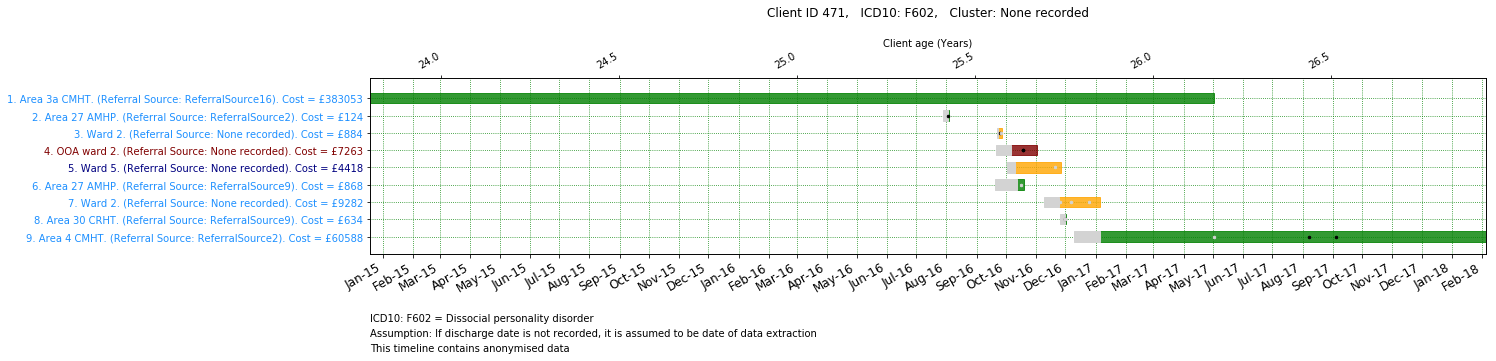

In [20]:
for ThisClientID in CLIENTS:
    client_data = DATA[DATA.ClientID == ThisClientID].copy(deep = True)
    client_data = sort_data(client_data, ORDER_ON_COST)
    client_data = add_string_counter_column(client_data)

    # Construct the string for the y axis label
    # The order + service team + referral source + cost    
    client_data['ylabel'] = (client_data.counter_str + ". " + 
                                client_data.WardTeam + 
                                ". (Referral Source: " + 
                                client_data.ReferralSource + 
                                ")" + ". Cost = £" + 
                                client_data.Episode_cost_str)
                                
    create_service_use_timeline(client_data, FOLDER)